## Project: Sign Language Digits Classification

#### Paper: Based on MobileNetV2 architecture https://arxiv.org/ftp/arxiv/papers/1710/1710.06836.pdf

In [1]:
%matplotlib inline

In [30]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import seaborn as sea

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Input, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.metrics import confusion_matrix

### Data source

The data is downloadable from Kaggle, https://www.kaggle.com/uciml/sms-spam-collection-dataset

The dataset has 16 500 black and white images grouped in 11 categories - 0, 1, 2, ..., 9 and unknown. Each category has exactly 1500 records, so the data distribution is normal.

In [5]:
PATH = r'C:\Kate\AI_Research\04_Sign_Language_Numbers\Sign Language for Numbers'
PATH_0 = PATH + r'\0'
PATH_1 = PATH + r'\1'
PATH_2 = PATH + r'\2'
PATH_3 = PATH + r'\3'
PATH_4 = PATH + r'\4'
PATH_5 = PATH + r'\5'
PATH_6 = PATH + r'\6'
PATH_7 = PATH + r'\7'
PATH_8 = PATH + r'\8'
PATH_9 = PATH + r'\9'
PATH_UNKNOWN = PATH + r'\unknown'

IMG_WIDTH=28
IMG_HEIGHT=28

### Quick data visualization

<Figure size 2016x2016 with 0 Axes>

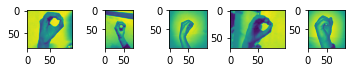

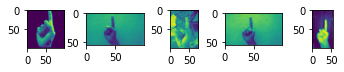

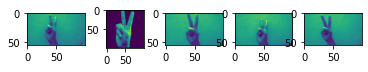

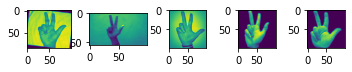

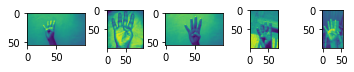

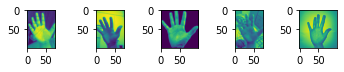

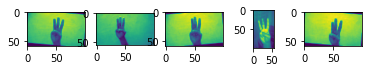

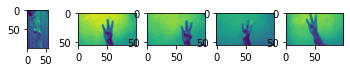

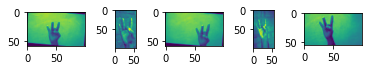

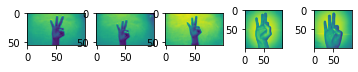

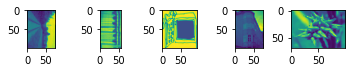

In [6]:
plt.figure(figsize=(IMG_HEIGHT, IMG_WIDTH))
folders_path = [PATH_0, PATH_1, PATH_2, PATH_3, PATH_4, PATH_5, PATH_6, PATH_7, PATH_8, PATH_9, PATH_UNKNOWN]
for path in folders_path:
    fig = plt.figure()
    for i in range(5):
        file = random.choice(os.listdir(path))
        image_path= os.path.join(path, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(5,5,i+1)
        new_plot = fig.add_subplot(ax)
        new_plot.imshow(img)        

### Read and preparation the data

Load a dataset from the local file

In [7]:
def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image= np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

img_data, labels =create_dataset(PATH)

In [8]:
print(len(img_data))
print('img data:', type(img_data))
print('labels: ', type(labels))

16500
img data: <class 'list'>
labels:  <class 'list'>


In [9]:
unique = list(dict.fromkeys(labels))
print(unique)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'unknown']


In [10]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
print("Label Encoder:", labels)

Label Encoder: [ 0  0  0 ... 10 10 10]


In [12]:
data = np.array(img_data, dtype="float32")
labels = np.array(labels)

### Train-Test Split Data

In [13]:
(train_image_data, test_image_data, train_label, test_label) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [14]:
label_binrizer = LabelBinarizer()
train_label = label_binrizer.fit_transform(train_label)
test_label = label_binrizer.fit_transform(test_label)

In [15]:
print(train_image_data.shape)
print(train_label.shape)

(13200, 28, 28)
(13200, 11)


In [16]:
train_image_data = train_image_data.reshape(-1, 28, 28, 1)
test_image_data = test_image_data.reshape(-1, 28, 28, 1)

### Image augmentation

In [18]:
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, zoom_range=0.2, horizontal_flip = True,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   fill_mode='nearest')

In [19]:
validation_datagen = ImageDataGenerator()

### Create CNN Model

In [20]:
model = tf.keras.Sequential()
model.add(Conv2D(filters= 3 , kernel_size=(3,3), padding = 'same', activation = 'relu' , input_shape = (28, 28,1)))
model.add(Conv2D(filters= 6, kernel_size=(3,3), padding = 'valid', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters= 32 , kernel_size=(3,3), padding = 'same', activation = 'relu' ))
model.add(Conv2D(filters= 64, kernel_size=(3,3), padding = 'valid', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters= 128 , kernel_size=(3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(filters= 256, kernel_size=(3,3), padding = 'valid', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(11, activation = 'softmax'))

In [21]:
model = tf.keras.Sequential()
model.add(Conv2D(filters= 3 , kernel_size=(3,3), padding = 'same', activation = 'relu' , input_shape = (28, 28,1)))
print('test')
model.add(MaxPool2D(pool_size=(2,2), strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3,3) , padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = 2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding = 'valid', activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2) , strides = 2))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(11, activation = 'softmax'))

test


In [22]:
model.compile(optimizer= 'adam' ,loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 3)         30        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 3)         12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)         

In [23]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

C:\Users\KateNonova\.conda\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [24]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [25]:
history = model.fit(train_datagen.flow(train_image_data, train_label),
                              epochs=60,
                              validation_data=validation_datagen.flow(test_image_data, test_label))

Epoch 1/60
413/413 [==============================] - 7s 16ms/step - loss: 2.0955 - accuracy: 0.3117 - val_loss: 2.3557 - val_accuracy: 0.2667
Epoch 2/60
413/413 [==============================] - 7s 16ms/step - loss: 1.6452 - accuracy: 0.4442 - val_loss: 1.5025 - val_accuracy: 0.5091
Epoch 3/60
413/413 [==============================] - 6s 15ms/step - loss: 1.3894 - accuracy: 0.5253 - val_loss: 1.8439 - val_accuracy: 0.4394
Epoch 4/60
413/413 [==============================] - 7s 16ms/step - loss: 1.2317 - accuracy: 0.5794 - val_loss: 1.5583 - val_accuracy: 0.5376
Epoch 5/60
413/413 [==============================] - 7s 17ms/step - loss: 1.1275 - accuracy: 0.6165 - val_loss: 0.7832 - val_accuracy: 0.7318
Epoch 6/60
413/413 [==============================] - 7s 16ms/step - loss: 1.0414 - accuracy: 0.6440 - val_loss: 1.0277 - val_accuracy: 0.6591
Epoch 7/60
413/413 [==============================] - 7s 16ms/step - loss: 0.9793 - accuracy: 0.6652 - val_loss: 0.8374 - val_accuracy: 0.7167

413/413 [==============================] - 8s 20ms/step - loss: 0.3510 - accuracy: 0.8847 - val_loss: 0.2309 - val_accuracy: 0.9255
Epoch 58/60
413/413 [==============================] - 8s 19ms/step - loss: 0.3506 - accuracy: 0.8836 - val_loss: 0.4582 - val_accuracy: 0.8591
Epoch 59/60
413/413 [==============================] - 8s 20ms/step - loss: 0.3617 - accuracy: 0.8770 - val_loss: 0.3043 - val_accuracy: 0.9030
Epoch 60/60
413/413 [==============================] - 8s 19ms/step - loss: 0.3478 - accuracy: 0.8820 - val_loss: 0.4172 - val_accuracy: 0.8736


### Evaluate

In [26]:
model.evaluate(test_image_data, test_label, verbose=0)

[0.4171718955039978, 0.8736363649368286]

<Figure size 1728x576 with 0 Axes>

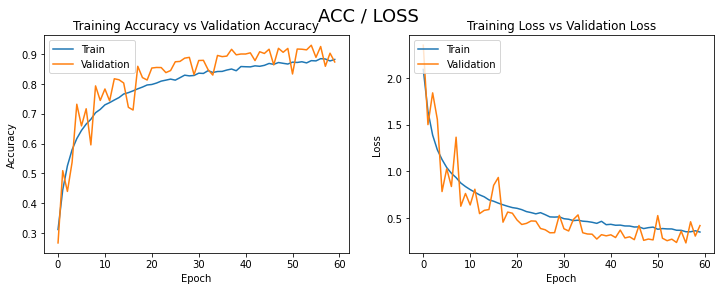

In [27]:
plt.figure(figsize=(24,8))


fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.suptitle("ACC / LOSS",fontsize=18)

plt.show()

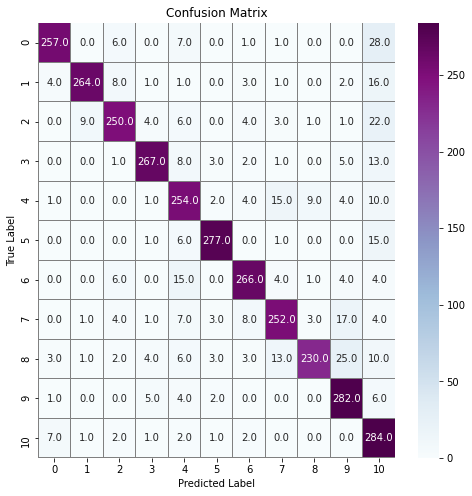

In [29]:
# Predict the values from the validation dataset
Y_pred = model.predict(test_image_data)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_label,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sea.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [32]:
print('Validation accuracy of the model: ',history.history['val_accuracy'][-1])

Validation accuracy of the model:  0.8736363649368286


## Test predictions

In [47]:
def model_prediction(image_path):
    SIGN_LANGUAGE_LIST = ["Zero","One", "Two",
                     "Three", "Four",
                     "Five", "Six",
                     "Seven", "Eight", "Nine", "Unknown"]
    image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    image=cv2.resize(image, (28, 28),interpolation = cv2.INTER_AREA)
    image= np.array(image)
    image = image.astype('float32')
    image /= 255 
    image = np.array(image, dtype="float32")
    test_image = image.reshape(-1, 28, 28, 1)
    #return print("Sign: ", SIGN_LANGUAGE_LIST[np.argmax(model.predict(test_image))],"\n", np.max(model.predict(test_image)),"%")
    return np.max(model.predict(test_image))

In [54]:
PATH_TEST = r'C:\Kate\AI_Research\04_Sign_Language_Numbers\Sign Language for Numbers\test'

In [55]:
avg_prediction_score = 0;
count = 0;
for filename in os.listdir(PATH_TEST):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_file_path = (os.path.join(path_test_directory, filename))
        score = model_prediction(img_file_path)
        avg_prediction_score +=score 
        count = count +1
    else:
        continue

print("Model average score is: ", avg_prediction_score/count,"%")

Model average score is:  0.9267190051349726 %
